In [36]:
%load_ext autoreload
%autoreload 2

import torch
from diffusers import ControlNetModel

from text3d2video.artifacts.animation_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
import torchvision.transforms.functional as TF
from text3d2video.generative_rendering import GenerativeRenderingPipeline

animation = AnimationArtifact.from_wandb_artifact_tag('joyful-jump:latest')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from pytorch3d.io import load_obj

device = torch.device("cuda")
verts, faces, aux = load_obj(animation.get_frame_path(1), device=device)

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [31]:
from pytorch3d.renderer import TexturesUV
from pytorch3d.structures import Meshes

texture_res = 100
empty_texture_map = torch.zeros((texture_res, texture_res, 3), device=device)


tex = TexturesUV(
    verts_uvs=[aux.verts_uvs.to(device)],
    faces_uvs=[faces.textures_idx.to(device)],
    maps=[empty_texture_map.to(device)],
)

mesh = Meshes(
    verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex
)

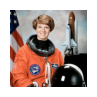

<Figure size 640x480 with 0 Axes>

In [39]:
from torchvision.io import read_image

image = read_image("data/collins.png")
display_ims([TF.to_pil_image(image)])

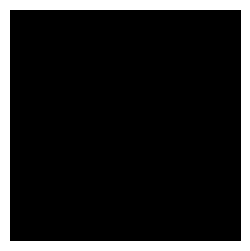

<Figure size 640x480 with 0 Axes>

In [63]:
from einops import rearrange
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import make_feature_renderer
from text3d2video.util import front_camera


camera = front_camera()
renderer = make_feature_renderer(camera, texture_res)

render = renderer(mesh)
render = TF.to_pil_image(rearrange(render, "1 h w c -> c h w"))

display_ims([render], scale=3)

In [67]:
from codetiming import Timer
from torch import Tensor

uv_coord = Tensor([0.5, 0.5]).to(device)

with Timer() as t:

    for triangle in mesh.faces_list()[0]:
        # indices of each vert in the triangle 
        a, b, c = triangle

        # get the uv coordinates of each vert in the triangle
        uv_a = mesh.textures.verts_uvs_list()[0][a]
        uv_b = mesh.textures.verts_uvs_list()[0][b]
        uv_c = mesh.textures.verts_uvs_list()[0][c]

        # calculate the barycentric coordinates of the uv_coord in the triangle
        v0 = uv_b - uv_a

Elapsed time: 2.3124 seconds


In [59]:
triangle_indices = mesh.faces_list()[0]
uvs = mesh.textures.verts_uvs_list()[0]
triangles = uvs[triangle_indices]

In [81]:
p = Tensor([0.5, 0.5])
t = triangles[0]

area_abc = 0.5 * (t[0][0] * (t[1][1] - t[2][1]) + t[1][0] * (t[2][1] - t[0][1]) + t[2][0] * (t[0][1] - t[1][1]))
area_abc

tensor(-0.0197, device='cuda:0')